In [1]:
import glob
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import numpy as np
import os
import sys
import pandas as pd

current_folder = os.getcwd()
if current_folder not in sys.path:
    sys.path.append(current_folder)


In [12]:
def load_cache(save_dir, experiment, expid, metric, until = None):
    exp_path = f"{save_dir}/{experiment}/{expid}"
    step_names = glob.glob(f"{exp_path}/metrics/*.tar")
    step_list = [int(s.split(".tar")[0].split("step")[1]) for s in step_names]
    steps, cache = [], []
    for in_filename, step in tqdm(sorted(list(zip(step_names, step_list)), key=lambda x: x[1])):
        if until is not None and step >= until:
            break
        checkpoint = torch.load(in_filename)
        if metric in checkpoint.keys():
            steps.append(step)
            cache.append(checkpoint[metric])
    return np.array(steps), np.array(cache)

In [3]:
def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=20)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=20)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.ticklabel_format(axis="x", useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

In [5]:
CACHE_PATH = "results/cifar10"
experiment = "small_data"
expid = "02"

100%|██████████| 1200/1200 [00:07<00:00, 158.20it/s]


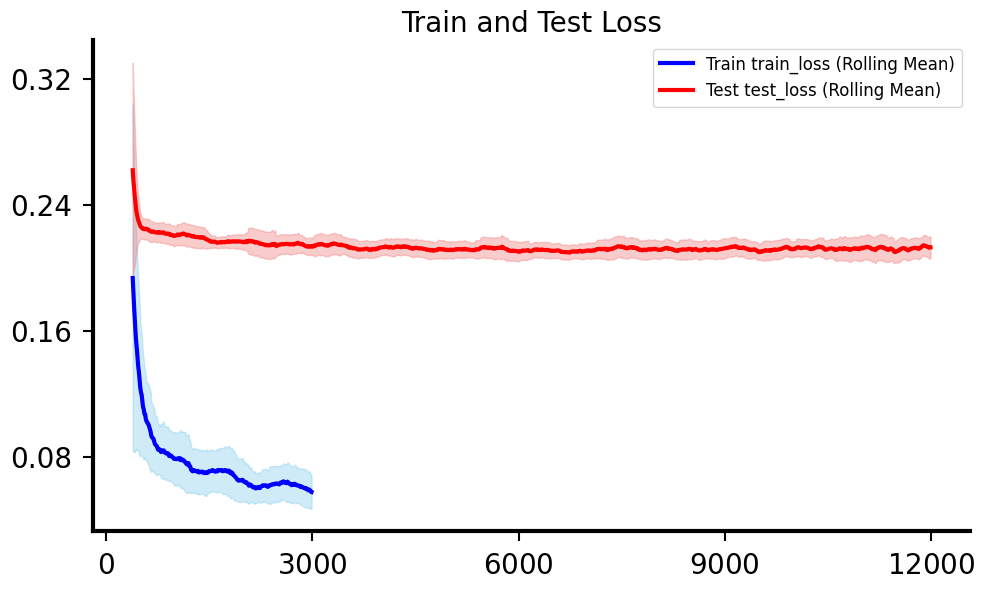

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

window_size = 40  # Adjust this for the size of the rolling window

# Train loss
metric = "train_loss"
x_train, y_train = load_cache(CACHE_PATH, experiment, expid, metric)
x_train = x_train / 40
y_train_series = pd.Series(y_train)
rolling_mean_train = y_train_series.rolling(window=window_size).mean()
rolling_std_train = y_train_series.rolling(window=window_size).std()
ax.plot(x_train, rolling_mean_train, label=f'Train {metric} (Rolling Mean)', linewidth=3.0, color='blue')
ax.fill_between(x_train, rolling_mean_train-rolling_std_train, rolling_mean_train+rolling_std_train, color='skyblue', alpha=0.4)

# Test loss
metric = "test_loss"
x_test, y_test = load_cache(CACHE_PATH, experiment, expid, metric)
x_test = x_test / 40
y_test_series = pd.Series(y_test)
rolling_mean_test = y_test_series.rolling(window=window_size).mean()
rolling_std_test = y_test_series.rolling(window=window_size).std()
ax.plot(x_test, rolling_mean_test, label=f'Test {metric} (Rolling Mean)', linewidth=3.0, color='red')
ax.fill_between(x_test, rolling_mean_test-rolling_std_test, rolling_mean_test+rolling_std_test, color='lightcoral', alpha=0.4)

style_axes(ax)
ax.set_title("Train and Test Loss", fontsize=20)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


  7%|▋         | 80/1200 [00:00<00:05, 190.07it/s]

100%|██████████| 50/50 [00:00<00:00, 174.62it/s]


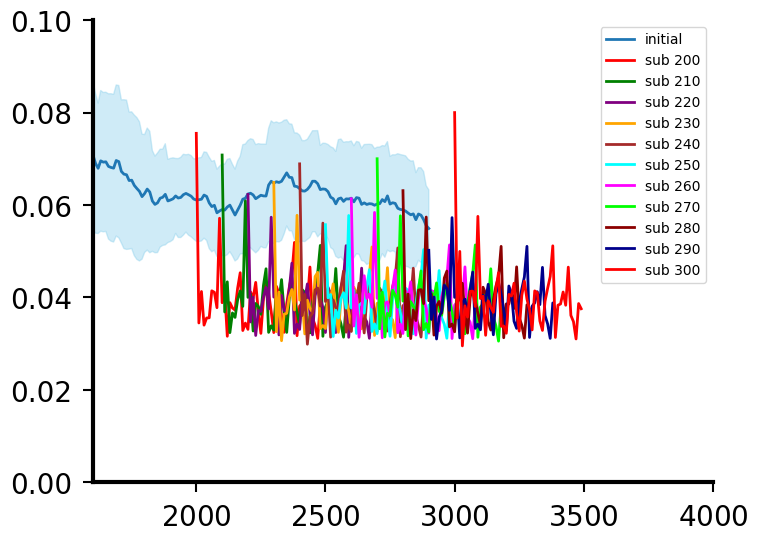

In [18]:
# next experiment: run 100 epochs with a smaller learning rate, starting from epoch 80
# SGDm
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))
metric = "train_loss"
window_size = 20  # Adjust this for the size of the rolling window

# Initial plot
x, y = load_cache(CACHE_PATH, experiment, expid, metric, until = 120000)
x = x / 40
y_series = pd.Series(y)
rolling_mean = y_series.rolling(window=window_size, center = True).mean()
rolling_std = y_series.rolling(window=window_size, center = True).std()
ax.plot(x, rolling_mean, label="initial", linewidth=2.0)
ax.fill_between(x, rolling_mean-rolling_std, rolling_mean+rolling_std, color='skyblue', alpha=0.4)

# Subsequent plots

colors = ['red', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'lime', 'darkred', 'darkblue']
for i in range(200, 301, 10):
    x, y = load_cache(CACHE_PATH, experiment + '/' + expid + '/sub2', str(i), metric)
    x = x / 40
    x = [a + i * 10 for a in x]
    y_series = pd.Series(y)
    window_size = 1
    rolling_mean = y_series.rolling(window=window_size, center = True).mean()
    rolling_std = y_series.rolling(window=window_size, center = True).std()
    color = colors[i // 10 % len(colors)] 
    ax.plot(x, rolling_mean, label="sub " + str(i), color = color, linewidth=2.0)
    ax.fill_between(x, rolling_mean-rolling_std, rolling_mean+rolling_std, color = color, alpha=0.4)  # Choose a color or let it default

style_axes(ax)
plt.legend()
plt.ylim(0, 0.10)
plt.xlim(1600, 4000)
plt.show()

In [ ]:
# cifar100 on resnet
# SGDm
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(10 * ncols, 6 * nrows))
CACHE_PATH = "../results/cifar100"
experiment = "resnet18"
expid = "01"
metric = "train_accuracy1"

x, y = load_cache(CACHE_PATH, experiment, expid, metric)
#x, y = x[1:], y[1:]
axes.plot(x, y, label="initial", linewidth=3.0)
y0 = y.copy()

for i in range(90,161,10):
    x, y = load_cache(CACHE_PATH, "resnet18_sub", str(i), metric)
    x = [a+i*391 for a in x]
    #y[10:] = [sum(y[i-10:i])/10 for i in range(10,len(y))]
    y[0] = y0[i-1]
    p = axes.plot(x, y, label="sub "+str(i), linewidth=2.0)
    #axes.plot([0,x[-1]], [y[-1],y[-1]], linewidth=1.5, color=p[0].get_color(),alpha=0.4)

plt.ylim([80,100])
plt.xlim([30000,100000])
plt.xlabel("iterations (391 iterations per epoch)", fontsize=20)
plt.ylabel(metric, fontsize=20)
plt.title(metric, fontsize=20)
style_axes(axes)
#plt.legend()
plt.savefig("figs0423/cifar100_resnet18_train_accuracy.png", bbox_inches="tight")
plt.show()

In [ ]:
# next we can check:
# 1.cross entropy loss
# 2.with label noise
# 3.smaller model, e.g. fnn on cifar10

In [ ]:
# cross entropy loss 
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))
CACHE_PATH = "../results/cifar100"
experiment = "resnet18"
expid = "ln"
metric = "test_accuracy1"

x, y = load_cache(CACHE_PATH, experiment, expid, metric)
axes.plot(x, y, label=metric, linewidth=3.0)
style_axes(axes)
plt.legend()
plt.show()

In [ ]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(10 * ncols, 6 * nrows))
CACHE_PATH = "../results/cifar100"
experiment = "resnet18"
expid = "ce"
metric = "test_accuracy1"

x, y = load_cache(CACHE_PATH, experiment, expid, metric)
#x, y = x[1:], y[1:]
axes.plot(x, y, label="initial", linewidth=3.0)
y0 = y.copy()

for i in range(40,161,20):
    x, y = load_cache(CACHE_PATH, "resnet18/ce_sub", str(i), metric)
    x = [a+i*391 for a in x]
    y[10:] = [sum(y[i-10:i])/10 for i in range(10,len(y))]
    y[0] = y0[i-1]
    p = axes.plot(x, y, label="sub "+str(i), linewidth=2.0)
    #axes.plot([0,x[-1]], [y[-1],y[-1]], linewidth=1.5, color=p[0].get_color(),alpha=0.4)

#plt.ylim([75,100])
#plt.xlim([40000,150000])
plt.xlabel("iterations (391 iterations per epoch)", fontsize=20)
plt.ylabel(metric, fontsize=20)
plt.title(metric, fontsize=20)
style_axes(axes)
#plt.legend()
#plt.savefig("figs0423/cifar100_resnet18_train_accuracy.png", bbox_inches="tight")
plt.show()

In [ ]:
# next experiments
# 1.direction and distance of parameter moving before and after lr decay
# 2.experiments with a simpler target function


In [ ]:
# the correlation of the final test error and the starting test error
CACHE_PATH = "results/cifar10"
experiment = "small_data"
expid = "01"
metric = "test_loss"

x0, y0 = load_cache(CACHE_PATH, experiment, expid, metric)
plt.figure(figsize=(6,6))

start, end = [], []

for i in range(200,1001,10):
    x, y = load_cache(CACHE_PATH, experiment, str(i), metric)
    plt.plot(y0[i], np.mean(y[-100:]), marker=".", markersize=6)
    start.append(y0[i])
    end.append(np.mean(y[-100:]))

print(np.corrcoef(start, end)[0][1])
plt.show()

In [ ]:
i=200
for e in end:
    plt.plot(i,e,'.', color="tab:blue", markersize=7)
    i += 10
plt.plot(np.arange(200,1001),y0[200:], color="tab:red")
plt.show()

In [ ]:
print(np.corrcoef(np.arange(51), end)[0][1])
plt.plot(np.arange(500,1001,10), end, '.', markersize=7, color="tab:blue")
plt.show()

In [ ]:
by, be = [], []
for i in range(2,10):
    x_y = np.arange(i*100, (i+1)*100+1)
    x_e = np.arange(i*100, (i+1)*100+1, 10)
    
    x_y = np.concatenate((np.reshape(x_y, (-1,1)), np.ones((101,1))), axis=1)
    x_e = np.concatenate((np.reshape(x_e, (-1,1)), np.ones((11,1))), axis=1)
    
    b_y = np.linalg.lstsq(x_y, y0[i*100:(i+1)*100+1])[0][0]
    b_e = np.linalg.lstsq(x_e, end[(i-2)*10:(i-1)*10+1])[0][0]
    
    by.append(b_y)
    be.append(b_e)
    
plt.figure()
plt.plot(by, '*', color="tab:red", markersize=10)
plt.plot(be, "^", color="tab:blue", markersize=10)
plt.show()

PCA results and landscape on PCA planes

In [ ]:
# pca information
pca_info = np.load("results/cifar10/small_data/01/pca_info.npz")
coords = pca_info["coords"]
pc = pca_info["pc"]

In [ ]:
# landscape information
metric = "train_loss"
res = np.zeros((42,31))
res = np.load("results/cifar10/small_data/04/pca_landscape_reg_3rd/pca_landscape_0.npz")[metric]
# for i in range(20):
#     data = np.load("results/cifar10/small_data/04/pca_landscape_reg_3rd/pca_landscape_"+str(i)+".npz")
#     r = data[metric]
#     res[i*4:i*4+4] = r

In [ ]:
# plot the result
X = np.arange(-20,22)
Y = np.arange(-15,16)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, res, levels=40)
fig.colorbar(cp) 
ax.set_title(metric)
ax.set_xlabel('pc_small')
ax.set_ylabel('large scale')
#ax.plot(coords[:,1], coords[:,0], color="tab:orange", markersize=6)
#ax.plot(coords[::10,1], coords[::10,0], color="tab:orange", linewidth=2)
#ax.plot(coords[-1,1], coords[-1,0], "*", color="tab:red", markersize=10)
#plt.savefig("figs0423/03/small_scale_1000/pc1_2_test", bbox_inches="tight")
plt.show()

In [ ]:
# training loss function from a single data
data = np.load("results/cifar10/small_data/01/pca_landscape.npz")
metric = "test_loss"
res = data[metric]

X = np.arange(-15,16)
Y = np.arange(-20,22)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, res, levels=30)
fig.colorbar(cp) 
ax.set_title(metric)
ax.set_xlabel('pc2')
ax.set_ylabel('pc1')
ax.plot(coords[50:,1], coords[50:,0], color="tab:orange", markersize=6)
# ax.plot(coords[::10,1], coords[::10,0], color="tab:orange", linewidth=2)
ax.plot(coords[-1,1], coords[-1,0], "*", color="tab:red", markersize=10)
#plt.savefig("figs0423/03/small_scale_1000/pc1_2_test", bbox_inches="tight")
plt.show()